In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions.normal import Normal
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
import torch.optim as optim
from torch.autograd import Variable
import numpy.random as rand
import numpy as np
import sys
import os
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
from sklearn.metrics import fbeta_score
from scipy.stats import norm
from matplotlib import gridspec


from bnn import BNNBayesbyBackprop, gauss_logpdf


In [2]:
df = pd.read_csv("./bigData/colMetaData.csv")

In [3]:
df.columns

Index(['Var', 'availRatio', 'nonZeroRatio'], dtype='object')

In [4]:
np.sum(df['availRatio'] == 1.0)

14386

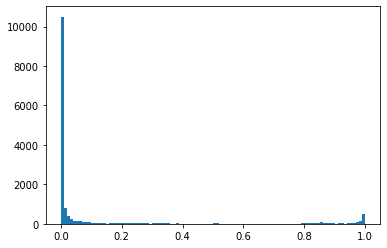

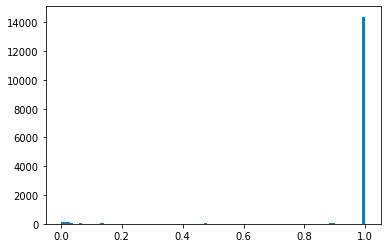

In [5]:
plt.hist(df['nonZeroRatio'], bins=100)
plt.show()


plt.hist(df['availRatio'], bins=100)
plt.show()

In [6]:
mask = df['nonZeroRatio'] > .1
mask = mask & (df['availRatio'] > .99)




print("{} variables will be used to train the model".format(np.sum(mask)))

variablesToKeep = list(df['Var'][mask])
print(variablesToKeep)

1838 variables will be used to train the model


['Var16', 'Var20', 'Var21', 'Var27', 'Var38', 'Var46', 'Var49', 'Var77', 'Var81', 'Var82', 'Var86', 'Var92', 'Var96', 'Var111', 'Var128', 'Var133', 'Var166', 'Var192', 'Var193', 'Var212', 'Var238', 'Var253', 'Var261', 'Var271', 'Var272', 'Var280', 'Var281', 'Var291', 'Var308', 'Var309', 'Var315', 'Var323', 'Var335', 'Var341', 'Var350', 'Var357', 'Var377', 'Var378', 'Var382', 'Var383', 'Var386', 'Var393', 'Var395', 'Var398', 'Var406', 'Var409', 'Var416', 'Var420', 'Var446', 'Var458', 'Var504', 'Var509', 'Var514', 'Var523', 'Var541', 'Var542', 'Var543', 'Var551', 'Var556', 'Var563', 'Var572', 'Var576', 'Var590', 'Var602', 'Var611', 'Var620', 'Var621', 'Var631', 'Var634', 'Var636', 'Var649', 'Var675', 'Var678', 'Var685', 'Var687', 'Var697', 'Var702', 'Var705', 'Var714', 'Var715', 'Var720', 'Var723', 'Var732', 'Var734', 'Var739', 'Var748', 'Var760', 'Var762', 'Var763', 'Var767', 'Var768', 'Var771', 'Var791', 'Var827', 'Var834', 'Var842', 'Var854', 'Var855', 'Var856', 'Var862', 'Var881', 'V

In [11]:
def loadData(varNames):
    categoryVars = ["Var{}".format(x) for x in list(range(14740,15000))]

    temp = []
    for v in varNames:
        if v not in categoryVars:
            temp.append(v)
    varNames = temp
    
        
    varNumbers = [int(x[3:]) for x in varNames]

    
    
    bigTrain1 = pd.read_csv("./bigData/orange_large_train.data.chunk1",
                            sep='\t', usecols=varNumbers, skiprows=[0], names=varNames)
    bigTrain2 = pd.read_csv("./bigData/orange_large_train.data.chunk2",
                            sep='\t', usecols=varNumbers, names=varNames)
    bigTrain3 = pd.read_csv("./bigData/orange_large_train.data.chunk3",
                            sep='\t', usecols=varNumbers, names=varNames)
    bigTrain4 = pd.read_csv("./bigData/orange_large_train.data.chunk4",
                            sep='\t', usecols=varNumbers, names=varNames)
    bigTrain5 = pd.read_csv("./bigData/orange_large_train.data.chunk5",
                            sep='\t', usecols=varNumbers, names=varNames)

    
    dfs = [bigTrain1, bigTrain2, bigTrain3, bigTrain4, bigTrain5]
    df = pd.concat(dfs)
    
    #df.fillna(df.mean(), axis=1, inplace=True)

    y = pd.read_csv("./bigData/y_train.csv")
    y['y'][y['y'] == -1.0] = 0
    y = y.as_matrix()[:,0]
    return df.as_matrix(), y
    

In [10]:
df.mean()

availRatio      0.966457
nonZeroRatio    0.117434
dtype: float64

In [12]:
X, y = loadData(variablesToKeep)

/home/emerson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/emerson/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


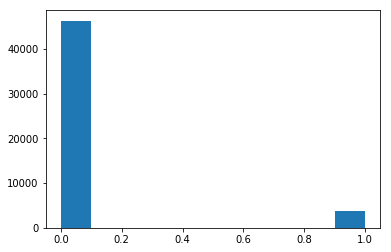

0.07344


In [13]:
plt.hist(y)
plt.show()

positives = np.sum(y == 1.0)
negatives = np.sum(y == 0.0)

print(positives / (positives + negatives))

In [15]:
perm = np.random.permutation(X.shape[0])
X = X[perm]
y = y[perm]


trainTestSplit = .8
index = int(X.shape[0] * .8)
X_train = X[:index,:]
X_test = X[index:, :]
y_train = y[:index]
y_test = y[index:]

In [ ]:
layerSize = 32
numLayers = 3
input_dim = X_train.shape[1]


bnn = BNNBayesbyBackprop(input_dim=input_dim, core_hidden_layers=[layerSize]*numLayers, mu_hidden_layers=[layerSize]*numLayers,
                         log_s_hidden_layers=[layerSize]*numLayers,
                         prior_mu=0.0, prior_s=1.0, num_MC_samples=80, classification=True)

bnn.fit(X_train, y_train, plot=True, n_epochs=200, learning_rate=5e-3, batch_size=3000)


Data being saved in following file:
logging.csv
Epoch:  0 	Loss:  311515.97 	acc:  0.612225
Epoch:  1 	Loss:  285373.9 	acc:  0.3519
Epoch:  2 	Loss:  266956.22 	acc:  0.162575
Epoch:  3 	Loss:  246852.86 	acc:  0.707675
Epoch:  4 	Loss:  241407.56 	acc:  0.911475
Epoch:  5 	Loss:  238316.73 	acc:  0.8958
Epoch:  6 	Loss:  231113.33 	acc:  0.75805
Epoch:  7 	Loss:  226962.69 	acc:  0.91275
Epoch:  8 	Loss:  190945.52 	acc:  0.52145
Epoch:  9 	Loss:  188705.12 	acc:  0.8962
Epoch:  10 	Loss:  179501.94 	acc:  0.9221


In [23]:
import summaryStatistics as sumStats



In [26]:
pList, rList, f1List, fBList = sumStats.prCurve(bnn, X_test, y_test)


[[9183  687]
 [ 114   16]]

[[9183  687]
 [ 114   16]]

[[9183  687]
 [ 114   16]]

[[9183  687]
 [ 114   16]]

[[9183  687]
 [ 114   16]]

[[9183  687]
 [ 114   16]]

[[9183  687]
 [ 114   16]]

[[9183  687]
 [ 114   16]]

[[9183  687]
 [ 114   16]]

[[9183  687]
 [ 114   16]]

[[9183  687]
 [ 114   16]]

[[9183  687]
 [ 114   16]]

[[9183  687]
 [ 114   16]]

[[9183  687]
 [ 114   16]]

[[9183  687]
 [ 114   16]]

[[9183  687]
 [ 114   16]]

[[9183  687]
 [ 114   16]]

[[9183  687]
 [ 114   16]]

[[9183  687]
 [ 114   16]]

[[9183  687]
 [ 114   16]]



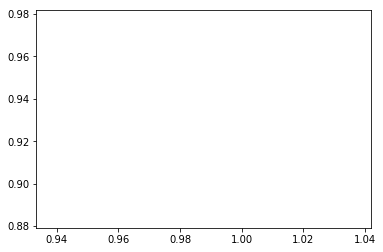

In [29]:
plt.plot(rList, pList)

In [130]:
y_pred = bnn.model.forward(torch.Tensor(X_test), predict = True, threshold=False).detach().numpy()

print(set(y_pred))

print(y_pred.shape)

numPos = np.sum(y_pred == 1.0)
numNeg = np.sum(y_pred == 0.0)

print(numPos)
print(numNeg)

print(numPos / (numNeg + numPos))

tensor([-3.3777e+09, -8.3644e+07, -1.6217e+09,  ..., -2.0739e+08,
        -9.2319e+08, -1.5795e+09], grad_fn=<SelectBackward>)
{0.0, 1.0}
here
{0.0, 1.0}
(10000,)
25
9975
0.0025


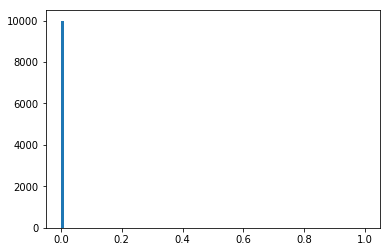

In [89]:
plt.hist(y_pred, bins=100)
plt.show()